In [ ]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel
# https://namyalg.medium.com/how-many-topics-4b1095510d0e
# https://papers.neurips.cc/paper/2010/file/71f6278d140af599e06ad9bf1ba03cb0-Paper.pdf
# https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2
# https://learn-scikit.oneoffcoder.com/gensim.html

### Import Libraries

In [2]:
# !pip install vaderSentiment;
# !pip install plotly
# !pip install gensim;

import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import os
from os import path
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 100
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import csv

display_images = False
analyze_headlines = True
analyze_articles = False
lemmatize = True
stem = False
analyze_subsample = True
repull_data = True
sources = ['CBS News', 'CNN', 'Fox News', 'The New York Times', 'USA Today','Washington Post']

In [1]:
# testing = True

# if testing:
    
#     df = pd.read_excel("all_years_subsample.xlsx")
#     df = df[["Document_No", "date", 'source', 'name', 'content']]
#     df = df.rename(columns={'headline': 'name', 'article': 'content'})

### Initialize DataFrame

In [ ]:
# repull_data = False

# if not repull_data and analyze_subsample:
#     df = pd.read_excel("all_years_subsample.xlsx")
# elif not repull_data and not analyze_subsample:
#     df = pd.read_excel("all_years.xlsx")
# else:
#     print("set up new data")

In [85]:
# create a new sample dataframe

df = pd.read_excel("all_years.xlsx")

if repull_data and analyze_subsample:

    size = 3000        # sample size
    replace = False  # without replacement
    fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
    df = df.groupby('source', as_index=False).apply(fn)  # each source gets same number of samples
    df = df.reset_index()
    df = df.drop(['level_0', 'level_1', 'edited_name', 'edited_content'],axis=1)

### Tokenize, Format, and Remove Stop Words

In [86]:
import contractions
import datetime as dt
from datetime import datetime
# nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 're', 'edu', 'use', 'https', 'said', 'us', 'cbs' 
                   'would', 'like','says', 'could', 'told', 'going', 'one', 'fox', 'cnn', 'nbc'])

if repull_data:
    
    df['orig_headline'] = df['name']
    df['orig_article'] = df['content']
    df = df.drop(['name', 'content'], axis=1)
    df['date']= pd.to_datetime(df['date'])
    df['headline'] = df['orig_headline'].apply(str).apply(lambda x: [contractions.fix(word) for word in x.split()])
    df['article'] = df['orig_article'].apply(str).apply(lambda x: [contractions.fix(word) for word in x.split()])
    df["tokenized_headline"] = df["headline"].apply(str).str.lower().str.replace('[^\w\s]','')
    df["tokenized_article"] = df["article"].apply(str).str.lower().str.replace('[^\w\s]','')
    df['tokenized_headline'] = df['tokenized_headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])).str.split()
    df['tokenized_article'] = df['tokenized_article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])).str.split()
    df = df.drop_duplicates(["orig_article"])
    df = df[df['tokenized_article'].notnull()]

df.head()

<ipython-input-86-191f56f6fa3d>:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df["tokenized_headline"] = df["headline"].apply(str).str.lower().str.replace('[^\w\s]','')
<ipython-input-86-191f56f6fa3d>:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df["tokenized_article"] = df["article"].apply(str).str.lower().str.replace('[^\w\s]','')


,Unnamed: 0,date,source,orig_headline,orig_article,headline,article,tokenized_headline,tokenized_article
0,115568,2018-11-20,CBS News,Ivanka Trump used personal email for government business,[CBSN](https://www.cbsnews.com/live/?ftag=CNM-00-10aac7b) [_x000D_\n](https://www.cbsnews.com/li...,"[Ivanka, Trump, used, personal, email, for, government, business]","[[CBSN](https://www.cbsnews.com/live/?ftag=CNM-00-10aac7b), [_x000D_, ](https://www.cbsnews.com/...","[ivanka, trump, used, personal, email, government, business]","[cbsnhttpswwwcbsnewscomliveftagcnm0010aac7b, _x000d_, httpswwwcbsnewscomliveftagcnm0010aac7b, wa..."
1,27350,2020-08-05,CBS News,Trump campaign calls for early September debate ahead of early voting,Washington — President Trump 's campaign is requesting a fourth presidential debate to be schedu...,"[Trump, campaign, calls, for, early, September, debate, ahead, of, early, voting]","[Washington, —, President, Trump, 's, campaign, is, requesting, a, fourth, presidential, debate,...","[trump, campaign, calls, early, september, debate, ahead, early, voting]","[washington, president, trump, campaign, requesting, fourth, presidential, debate, scheduled, fi..."
2,23628,2020-05-28,CBS News,Perfectly preserved ancient Roman mosaic floor unearthed beneath Italian vineyard,Archaeologists in northern Italy have uncovered a rare gem — an amazingly well-preserved mosaic ...,"[Perfectly, preserved, ancient, Roman, mosaic, floor, unearthed, beneath, Italian, vineyard]","[Archaeologists, in, northern, Italy, have, uncovered, a, rare, gem, —, an, amazingly, well-pres...","[perfectly, preserved, ancient, roman, mosaic, floor, unearthed, beneath, italian, vineyard]","[archaeologists, northern, italy, uncovered, rare, gem, amazingly, wellpreserved, mosaic, floor,..."
3,36567,2020-12-10,CBS News,"Detained Chinese citizen-journalist restrained to stop her from continuing hunger strike, lawyer...","Detained Chinese citizen-journalist restrained to stop her from continuing hunger strike , lawye...","[Detained, Chinese, citizen-journalist, restrained, to, stop, her, from, continuing, hunger, str...","[Detained, Chinese, citizen-journalist, restrained, to, stop, her, from, continuing, hunger, str...","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer]","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer, chi..."
4,142137,2019-01-15,CBS News,Fiscal board asks court to invalidate $6 billion of Puerto Rico's debt,The oversight board established by Congress to manage Puerto Rico 's fiscal crisis asked a feder...,"[Fiscal, board, asks, court, to, invalidate, $6, billion, of, Puerto, Rico's, debt]","[The, oversight, board, established, by, Congress, to, manage, Puerto, Rico, 's, fiscal, crisis,...","[fiscal, board, asks, court, invalidate, 6, billion, puerto, ricos, debt]","[oversight, board, established, congress, manage, puerto, rico, fiscal, crisis, asked, federal, ..."


In [87]:
# Remove unnamed columns

for column_name in df.columns:
    if "Unnamed:" in column_name:
        df = df.drop(column_name, axis=1)

### Perform Text Stemming

In [88]:
from nltk.stem.porter import PorterStemmer

if repull_data and stem:

    porter_stemmer = PorterStemmer()

    #defining a function for stemming
    def stemming(text):
        stem_text = [porter_stemmer.stem(word) for word in text]
        return stem_text

    df['stemmed_headline'] = df['tokenized_headline'].apply(lambda x: stemming(x))
    df['stemmed_article'] = df['tokenized_article'].apply(lambda x: stemming(x))

    df.head()

### Perform Text Lemmatization

In [89]:
from nltk.stem import WordNetLemmatizer

if repull_data and lemmatize:

    #defining a function for lemmatizing
    def lemmatizing(text):
        
        wordnet_lemmatizer = WordNetLemmatizer()
        
        lem_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
        return lem_text

    df['lemmatized_headline'] = df['tokenized_headline'].apply(lambda x: lemmatizing(x))
    df['lemmatized_article'] = df['tokenized_article'].apply(lambda x: lemmatizing(x))

### Verify Column Data Types

In [91]:
# run each time you pull the data

# columns that have list elements
columns = ['tokenized_headline', 'tokenized_article', 'lemmatized_headline', 'lemmatized_article']

if not repull_data:
    for feature in columns:

        if type(df[feature][0]) == str:
            df[feature] = df[feature].apply(lambda x: x.strip('][').split(', '))
            df[feature] = df[feature].apply(lambda x: [i.replace('"', '').replace("'", "") for i in x])

        # # should alternate list and string
        print(type(df[feature][0]))  
        print(type(df[feature][0][0]))  

    # df.head()

## Assign Text Data for Analysis

In [92]:
if analyze_headlines:
    original_text = df['orig_headline']
    text = df['headline']
    text_data = df['lemmatized_headline']
else:
    original_text = df['orig_article']
    text = df['article']
    text_data = df['lemmatized_article']

## General Functions

In [94]:
# displays topic examples and predicted topics for an example headline

def print_topic_examples(model, model_type):
    print("The first 3 topics of the {} model:".format(model_type))
    print("-----------------------------------------------\n")
    
    for idx, topic in model.print_topics(num_topics=3):
        print('Topic: {} \nWords: {}'.format(idx, topic))

    print("\n\nOur {} model's top 3 predicted topic for the following headline:\n{}".format(model_type, df['orig_headline'].iloc[4310]))
    print("------------------------------------------------------------------------------------------")
    i = 0
    for index, score in sorted(model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
        print("\nScore: {:.3}\t \nTopic: {}".format(score, model.print_topic(index, 8))) # top 8 words for topic
        i += 1
        if i > 2:
            break

In [95]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#13viewthetopicsinldamodel

from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step, analysis):
    """
    Compute c_v coherence for various number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        if analysis == 'LDA':
            model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = 0)
        if analysis == 'LSI':
            model = gensim.models.LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        if analysis == 'HDP':
             model = gensim.models.hdpmodel.HdpModel(corpus=tfidf_corpus, T=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

min_topics = 10
max_topics = 65
step = 5

In [96]:
# Plot coherence scores for determining number of topics

def plot_coherence_scores(min_topics, max_topics, step, model_list, coherence_values, model_type):
    x = range(min_topics, max_topics, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.title("{} - Coherence Score by Number of Topics".format(model_type))
    plt.show()

    max_index = coherence_values.index(max(coherence_values))
    
    if model_type != "HDP":
        best_number = model_list[max_index].num_topics
    else:
        best_number = len(model_list[max_index].get_topics())

    print("The best number of topics is {}".format(best_number))
    return best_number

In [97]:
# provide a dominant topic label for each text input

def determine_dominant_topics(model, corpus, texts):
    # Init output
    sentence_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(model[corpus]):
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sentence_topics_df = sentence_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), 
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sentence_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
#     contents = pd.Series(texts)
    sentence_topics_df['Text'] = texts
    return(sentence_topics_df)

In [98]:
# Show individual headlines most strongly associated with each topic

def show_representative_headlines(df_dominant_topic, column_name):

    representative_sentences = pd.DataFrame()

    sentence_topics_grouped = df_dominant_topic.groupby(column_name) # group by function

    for i, grp in sentence_topics_grouped:
        representative_sentences = pd.concat([representative_sentences, 
                                                 grp.sort_values(['Topic_%'], ascending=[0]).head(1)], 
                                                axis=0)

    # # Reset Index and format
    representative_sentences.reset_index(drop=True, inplace=True)
    representative_sentences.columns = ['Doc_No', column_name, "Topic_%", "Keywords", "Text"]
    return representative_sentences

In [99]:
# returns a sentiment classification matrix for each source - regardless of topic

def overall_sentiment_counts(df, colname):
    
    sentiment_matrix = [[0 for _ in range(3)] for _ in range(6)]
    
    for j in range(len(sources)):

        sub_df = df[df['source'] == sources[j]]

        sentiment_matrix[j][0] = list(sub_df.loc[sub_df[colname] == 'positive'].count())[0]
        sentiment_matrix[j][1] = list(sub_df.loc[sub_df[colname] == 'neutral'].count())[0]
        sentiment_matrix[j][2] = list(sub_df.loc[sub_df[colname] == 'negative'].count())[0]
    
    return sentiment_matrix

In [100]:
# returns a sentiment count matrix for each topic and source

def topic_sentiment_counts(df, colname):
    
    if analyze_headlines:
        col = 'Headline_Topic_LDA'
    else:
        col = 'Article_Topic_LDA'
        
    x = [[[0 for _ in range(3)] for _ in range(6)] for _ in range(5)] 
    
    for i in range(len(top_5_topics)):
    
        for j in range(len(sources)):
            
            
             
            sub_df = df[df[col] == top_5_topics[i]]
            sub_df = sub_df[sub_df['source'] == sources[j]]
            
            num_articles = len(sub_df)
            article_counts[i][j] = num_articles
            
            x[i][j][0] = list(sub_df.loc[sub_df[colname] == 'positive'].count())[0]/num_articles
            x[i][j][1] = list(sub_df.loc[sub_df[colname] == 'neutral'].count())[0]/num_articles
            x[i][j][2] = list(sub_df.loc[sub_df[colname] == 'negative'].count())[0]/num_articles
    
    return x

In [101]:
def plot_tsne(colors):
    
    fig, axs = plt.subplots(2, 3, figsize=(12,6), tight_layout=True)
    j = 0
    
    for perp in perplex:

        axs[0][j].scatter(x=tsne_dict["perplexity {}".format(perp)][:,0], 
                          y=tsne_dict["perplexity {}".format(perp)][:,1], c = colors,
                       alpha = 0.5)
        axs[0][j].set_title("TSNE - Perplexity {}".format(perp), fontsize=14)
        axs[0][j].set_xlabel("t-SNE 2D One")
        axs[0][j].set_ylabel("t-SNE 2D One")
        
        axs[1][j].scatter(x=tsne_dict["perplexity {}".format(perp)][:,0], 
                  y=tsne_dict["perplexity {}".format(perp)][:,1], c = colors, alpha = 0.5)
        axs[1][j].set_title("TSNE - Perplexity {}".format(perp), fontsize=14)
        axs[1][j].set_xlabel("t-SNE 2D One")
        axs[1][j].set_ylabel("t-SNE 2D One")
        axs[1][j].set_ylim([-10, 10])
        axs[1][j].set_xlim([-10, 10])
        
        j = j + 1

    return plt.show()

In [102]:
# https://www.tutorialspoint.com/plotly/plotly_3d_scatter_and_surface_plot.htm
# https://plotly.com/python/3d-scatter-plots/

import plotly.graph_objs as go

def plot_pca(color, reduced_features):
    
    color = color

    x = reduced_features[:,0]
    y = reduced_features[:,1]
    z = reduced_features[:,2]

    trace = go.Scatter3d(
       x = x, y = y, z = z,mode = 'markers', marker = dict(
          size = 2,
          color = color, # set color to an array/list of desired values
          colorscale = 'Rainbow'
          )
       )
    layout = go.Layout(title = '3D Scatter plot')
    fig = go.Figure(data = [trace], layout = layout)

    return fig.show()

## LDA Bag of Words Topic Model

#### https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

In [103]:
# text data defined above 'general functions'. Is either the headline or article content dataframe column
dictionary = gensim.corpora.Dictionary(text_data)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=1000)
# dictionary.filter_n_most_frequent(2)
# dictionary.most_common()

In [104]:
# turn dictionary into bag of words.
bow_corpus = [dictionary.doc2bow(doc) for doc in text_data]  # iterate over column in dataframe

bow_doc_4310 = bow_corpus[4310]  # example headline

#### https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

### Determine best number of topics - BoW

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

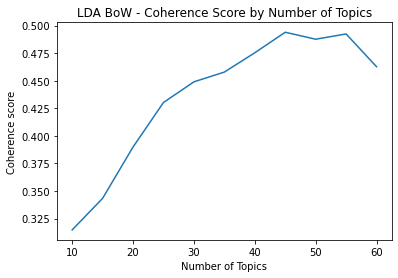

The best number of topics is 45


In [29]:
# test different number of topics and store in lists
model_list_bow, coherence_values_bow = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus,
                                                        texts=text_data, start=min_topics, 
                                                        limit=max_topics, step=step, analysis = 'LDA')

# plot coherence values and find best number of topics
best_number_bow = plot_coherence_scores(min_topics, max_topics, step, model_list_bow, coherence_values_bow, 'LDA BoW')

### Create Model with Appropriate Topic Number - BoW

In [126]:
# topic model with best number of topics
lda_model_bow = gensim.models.LdaModel(bow_corpus, chunksize = 100, iterations = 100, num_topics=best_number_bow, 
                                   id2word=dictionary, passes=10, random_state = 0)

print_topic_examples(lda_model_bow, "LDA - Bag of Words")

The first 3 topics of the LDA - Bag of Words model:
-----------------------------------------------

Topic: 33 
Words: 0.269*"covid19" + 0.254*"president" + 0.220*"trump" + 0.129*"world" + 0.117*"leader" + 0.000*"racism" + 0.000*"final" + 0.000*"dangerous" + 0.000*"bernie" + 0.000*"already"
Topic: 4 
Words: 0.001*"caucus" + 0.001*"memo" + 0.001*"bernie" + 0.001*"already" + 0.001*"racism" + 0.001*"final" + 0.001*"1" + 0.001*"offer" + 0.001*"key" + 0.001*"congressional"
Topic: 10 
Words: 0.264*"claim" + 0.177*"school" + 0.143*"surge" + 0.111*"warren" + 0.091*"fauci" + 0.077*"medical" + 0.038*"officer" + 0.036*"effect" + 0.025*"senior" + 0.015*"card"


Our LDA - Bag of Words model's top 3 predicted topic for the following headline:
In contrast with Trump legal team, Justice Department lawyer says House can impeach over defied subpoenas
------------------------------------------------------------------------------------------

Score: 0.337	 
Topic: 0.254*"trump" + 0.221*"impeachment" + 0.2

In [105]:
# list of topics, keywords, and coherence scores
top_topics = lda_model_bow.top_topics(bow_corpus) 

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / best_number_bow
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -17.4432.


### Assign Dominant Topic per Headline - BoW

6000 length dataframe with the highest probability topic labeled as the dominant topic for the headline

In [108]:
# dataframe indicating which topic to assign each document
if analyze_headlines:
    column_name = 'Headline_Topic_LDA_BoW'
else:
    column_name = 'Article_Topic_LDA_BoW'

df_dominant_topics_bow = determine_dominant_topics(lda_model_bow, bow_corpus, texts=text_data)
  
# # format
df_dominant_topics_bow = df_dominant_topics_bow.reset_index() 
df_dominant_topics_bow.columns = ['Document_No', column_name, 'Topic_%', 'Keywords', 'Text Input']
df_dominant_topics_bow[column_name] = df_dominant_topics_bow[column_name].astype(int)
df_dominant_topics_bow["Topic_%"] = round(df_dominant_topics_bow["Topic_%"]*100)
df_dominant_topics_bow.head()

df[column_name] = df_dominant_topics_bow[column_name]
df.head()

,date,source,orig_headline,orig_article,headline,article,tokenized_headline,tokenized_article,lemmatized_headline,lemmatized_article,Headline_Topic_LDA_BoW
0,2018-11-20,CBS News,Ivanka Trump used personal email for government business,[CBSN](https://www.cbsnews.com/live/?ftag=CNM-00-10aac7b) [_x000D_\n](https://www.cbsnews.com/li...,"[Ivanka, Trump, used, personal, email, for, government, business]","[[CBSN](https://www.cbsnews.com/live/?ftag=CNM-00-10aac7b), [_x000D_, ](https://www.cbsnews.com/...","[ivanka, trump, used, personal, email, government, business]","[cbsnhttpswwwcbsnewscomliveftagcnm0010aac7b, _x000d_, httpswwwcbsnewscomliveftagcnm0010aac7b, wa...","[ivanka, trump, used, personal, email, government, business]","[cbsnhttpswwwcbsnewscomliveftagcnm0010aac7b, _x000d_, httpswwwcbsnewscomliveftagcnm0010aac7b, wa...",22
1,2020-08-05,CBS News,Trump campaign calls for early September debate ahead of early voting,Washington — President Trump 's campaign is requesting a fourth presidential debate to be schedu...,"[Trump, campaign, calls, for, early, September, debate, ahead, of, early, voting]","[Washington, —, President, Trump, 's, campaign, is, requesting, a, fourth, presidential, debate,...","[trump, campaign, calls, early, september, debate, ahead, early, voting]","[washington, president, trump, campaign, requesting, fourth, presidential, debate, scheduled, fi...","[trump, campaign, call, early, september, debate, ahead, early, voting]","[washington, president, trump, campaign, requesting, fourth, presidential, debate, scheduled, fi...",27
2,2020-05-28,CBS News,Perfectly preserved ancient Roman mosaic floor unearthed beneath Italian vineyard,Archaeologists in northern Italy have uncovered a rare gem — an amazingly well-preserved mosaic ...,"[Perfectly, preserved, ancient, Roman, mosaic, floor, unearthed, beneath, Italian, vineyard]","[Archaeologists, in, northern, Italy, have, uncovered, a, rare, gem, —, an, amazingly, well-pres...","[perfectly, preserved, ancient, roman, mosaic, floor, unearthed, beneath, italian, vineyard]","[archaeologists, northern, italy, uncovered, rare, gem, amazingly, wellpreserved, mosaic, floor,...","[perfectly, preserved, ancient, roman, mosaic, floor, unearthed, beneath, italian, vineyard]","[archaeologist, northern, italy, uncovered, rare, gem, amazingly, wellpreserved, mosaic, floor, ...",0
3,2020-12-10,CBS News,"Detained Chinese citizen-journalist restrained to stop her from continuing hunger strike, lawyer...","Detained Chinese citizen-journalist restrained to stop her from continuing hunger strike , lawye...","[Detained, Chinese, citizen-journalist, restrained, to, stop, her, from, continuing, hunger, str...","[Detained, Chinese, citizen-journalist, restrained, to, stop, her, from, continuing, hunger, str...","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer]","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer, chi...","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer]","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer, chi...",27
4,2019-01-15,CBS News,Fiscal board asks court to invalidate $6 billion of Puerto Rico's debt,The oversight board established by Congress to manage Puerto Rico 's fiscal crisis asked a feder...,"[Fiscal, board, asks, court, to, invalidate, $6, billion, of, Puerto, Rico's, debt]","[The, oversight, board, established, by, Congress, to, manage, Puerto, Rico, 's, fiscal, crisis,...","[fiscal, board, asks, court, invalidate, 6, billion, puerto, ricos, debt]","[oversight, board, established, congress, manage, puerto, rico, fiscal, crisis, asked, federal, ...","[fiscal, board, asks, court, invalidate, 6, billion, puerto, rico, debt]","[oversight, board, established, congress, manage, puerto, rico, fiscal, crisis, asked, federal, ...",0


### Most Representative Headline per Topic - BoW

In [ ]:
# show_representative_headlines(df_dominant_topics_bow, column_name).head()

### Number of Headlines per Topic - BoW

In [109]:
# Number of Documents for Each Topic
topic_counts = df_dominant_topics_bow[column_name].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = 100*round(topic_counts/topic_counts.sum(), 3)

# Topic Keywords
topic_num_keywords = df_dominant_topics_bow[['Keywords']]

# Concatenate Column wise
dominant_topic_counts_bow = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
dominant_topic_counts_bow.columns = ['Topic_Keywords', 'Num_Documents', '%_Documents']
dominant_topic_counts_bow = dominant_topic_counts_bow.head(best_number_bow)
dominant_topic_counts_bow.insert(0, "Topic", dominant_topic_counts_bow.index.astype(int))
dominant_topic_counts_bow = dominant_topic_counts_bow.fillna(0.0)
dominant_topic_counts_bow.Num_Documents = dominant_topic_counts_bow.Num_Documents.astype(int)

# dominant_topic_counts_bow.head()

top_bow_topics = dominant_topic_counts_bow.sort_values(by='Num_Documents', ascending = False).head()

### Visualize Distribution of Topics Between News Sources - LDA BoW

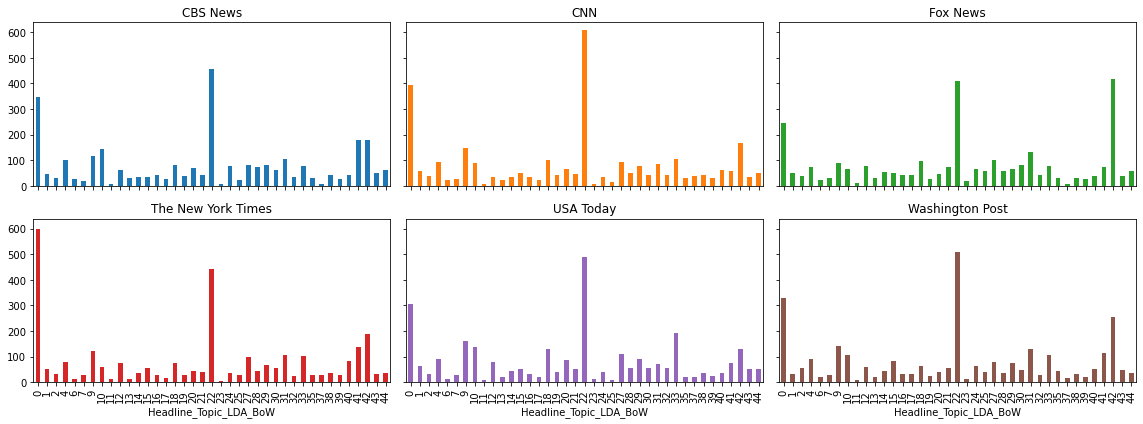

In [110]:
grouped_by_topic_source_bow = df.groupby(['source', column_name])
counts_per_source_bow = grouped_by_topic_source_bow[column_name].count()

ax = counts_per_source_bow.unstack(level=0).plot(kind='bar', subplots=True,
                                             sharey=True, rot=90, figsize=(16, 6), layout=(2, 3), legend=False)
plt.tight_layout()

In [127]:
# !pip install pyLDAvis
# !pip install pandas==1.3.1
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model_bow, bow_corpus, dictionary)
lda_viz

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
21    -0.238914 -0.368159       1        1  7.236398
18    -0.120439  0.085147       2        1  4.396047
44    -0.076736  0.063756       3        1  3.689157
17    -0.189235 -0.334361       4        1  3.665136
33    -0.201752 -0.314767       5        1  3.190372
15    -0.049284  0.048874       6        1  3.131180
22    -0.047504  0.048567       7        1  3.076727
5     -0.056242  0.051835       8        1  3.075197
20    -0.083336  0.067497       9        1  3.024919
29    -0.045851  0.047857      10        1  2.796451
0     -0.053606  0.053985      11        1  2.774350
3     -0.076968  0.065513      12        1  2.771977
41    -0.060769  0.055307      13        1  2.692424
35    -0.037569  0.044610      14        1  2.612334
28    -0.059669  0.054567      15        1  2.591970
12    -0.013508  0.034159      16        1  2.586291
7     -0.051716  0.052129      17        1  2.540951
42    -0.028625  0.040300      18        1  2.486343
6     -0.055412  0.056170      19        1  2.441765
11    -0.064837  0.059265      20        1  2.386088
30    -0.062162  0.059930      21        1  2.363828
25    -0.020247  0.035532      22        1  2.343047
1     -0.051792  0.052862      23        1  2.296994
10    -0.034608  0.043799      24        1  2.229457
14    -0.028469  0.042031      25        1  2.050070
37    -0.014114  0.035137      26        1  1.939174
24    -0.025060  0.041614      27        1  1.771807
39    -0.005942  0.033152      28        1  1.683048
9     -0.019106  0.039176      29        1  1.674308
16    -0.021155  0.038513      30        1  1.667602
23    -0.043507  0.051487      31        1  1.631817
32    -0.015597  0.038512      32        1  1.580058
38     0.030517  0.015482      33        1  1.381702
36     0.012138  0.024368      34        1  1.381488
19     0.060782  0.002354      35        1  1.366290
40     0.020224  0.020741      36        1  1.346562
43     0.043815  0.009563      37        1  1.230969
34     0.127572 -0.028831      38        1  1.074011
27     0.095631 -0.013846      39        1  1.048963
26     0.095663 -0.014133      40        1  1.045744
13     0.163751 -0.045001      41        1  1.006973
2      0.325909 -0.098674      42        1  0.680003
4      0.325909 -0.098674      43        1  0.680003
8      0.325909 -0.098674      44        1  0.680003
31     0.325909 -0.098674      45        1  0.680003, topic_info=            Term         Freq        Total Category  logprob  loglift
4          trump  7235.000000  7235.000000  Default  30.0000  30.0000
74   coronavirus  3790.000000  3790.000000  Default  29.0000  29.0000
37         biden  1613.000000  1613.000000  Default  28.0000  28.0000
168     election  1270.000000  1270.000000  Default  27.0000  27.0000
222     pandemic  1304.000000  1304.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
24          iran     0.618877   564.803793  Topic45  -6.9078  -1.8255
26          send     0.618877   200.172622  Topic45  -6.9078  -0.7882
27         force     0.618877   445.510528  Topic45  -6.9078  -1.5882
28       freedom     0.618877    43.036579  Topic45  -6.9078   0.7489
29         group     0.618877   241.017660  Topic45  -6.9078  -0.9739

[2318 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
279       8  0.945658    15
279      42  0.012779    15
279      43  0.012779    15
279      44  0.012779    15
279      45  0.012779    15
...     ...       ...   ...
48       31  0.995844  yous
48       42  0.000897  yous
48       43  0.000897  yous
48       44  0.000897  yous
48       45  0.000897  yous

[1642 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 19, 45, 18, 34, 16, 23, 6, 21, 30, 1, 4, 42, 36, 29, 13, 8, 43, 7, 12, 31, 26, 2, 11, 15, 38, 25, 40, 10, 17, 24, 3

In [128]:
# pyLDAvis.save_html(lda_viz, 'index_bow.html')

In [152]:
# https://stackoverflow.com/questions/59418433/how-to-get-document-topics-using-models-hdpmodel-hierarchical-dirichlet-proces

dir(lda_model_bow[bow_corpus])
lda_model_bow[bow_corpus].__getitem__(3)

[(17, 0.20443895), (38, 0.6044483)]

In [143]:
df.head()

,date,source,orig_headline,orig_article,headline,article,tokenized_headline,tokenized_article,lemmatized_headline,lemmatized_article,Headline_Topic_LDA_BoW,Headline_Topic_LDA
0,2018-11-20,CBS News,Ivanka Trump used personal email for government business,[CBSN](https://www.cbsnews.com/live/?ftag=CNM-00-10aac7b) [_x000D_\n](https://www.cbsnews.com/li...,"[Ivanka, Trump, used, personal, email, for, government, business]","[[CBSN](https://www.cbsnews.com/live/?ftag=CNM-00-10aac7b), [_x000D_, ](https://www.cbsnews.com/...","[ivanka, trump, used, personal, email, government, business]","[cbsnhttpswwwcbsnewscomliveftagcnm0010aac7b, _x000d_, httpswwwcbsnewscomliveftagcnm0010aac7b, wa...","[ivanka, trump, used, personal, email, government, business]","[cbsnhttpswwwcbsnewscomliveftagcnm0010aac7b, _x000d_, httpswwwcbsnewscomliveftagcnm0010aac7b, wa...",22,19
1,2020-08-05,CBS News,Trump campaign calls for early September debate ahead of early voting,Washington — President Trump 's campaign is requesting a fourth presidential debate to be schedu...,"[Trump, campaign, calls, for, early, September, debate, ahead, of, early, voting]","[Washington, —, President, Trump, 's, campaign, is, requesting, a, fourth, presidential, debate,...","[trump, campaign, calls, early, september, debate, ahead, early, voting]","[washington, president, trump, campaign, requesting, fourth, presidential, debate, scheduled, fi...","[trump, campaign, call, early, september, debate, ahead, early, voting]","[washington, president, trump, campaign, requesting, fourth, presidential, debate, scheduled, fi...",27,15
2,2020-05-28,CBS News,Perfectly preserved ancient Roman mosaic floor unearthed beneath Italian vineyard,Archaeologists in northern Italy have uncovered a rare gem — an amazingly well-preserved mosaic ...,"[Perfectly, preserved, ancient, Roman, mosaic, floor, unearthed, beneath, Italian, vineyard]","[Archaeologists, in, northern, Italy, have, uncovered, a, rare, gem, —, an, amazingly, well-pres...","[perfectly, preserved, ancient, roman, mosaic, floor, unearthed, beneath, italian, vineyard]","[archaeologists, northern, italy, uncovered, rare, gem, amazingly, wellpreserved, mosaic, floor,...","[perfectly, preserved, ancient, roman, mosaic, floor, unearthed, beneath, italian, vineyard]","[archaeologist, northern, italy, uncovered, rare, gem, amazingly, wellpreserved, mosaic, floor, ...",0,0
3,2020-12-10,CBS News,"Detained Chinese citizen-journalist restrained to stop her from continuing hunger strike, lawyer...","Detained Chinese citizen-journalist restrained to stop her from continuing hunger strike , lawye...","[Detained, Chinese, citizen-journalist, restrained, to, stop, her, from, continuing, hunger, str...","[Detained, Chinese, citizen-journalist, restrained, to, stop, her, from, continuing, hunger, str...","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer]","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer, chi...","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer]","[detained, chinese, citizenjournalist, restrained, stop, continuing, hunger, strike, lawyer, chi...",27,12
4,2019-01-15,CBS News,Fiscal board asks court to invalidate $6 billion of Puerto Rico's debt,The oversight board established by Congress to manage Puerto Rico 's fiscal crisis asked a feder...,"[Fiscal, board, asks, court, to, invalidate, $6, billion, of, Puerto, Rico's, debt]","[The, oversight, board, established, by, Congress, to, manage, Puerto, Rico, 's, fiscal, crisis,...","[fiscal, board, asks, court, invalidate, 6, billion, puerto, ricos, debt]","[oversight, board, established, congress, manage, puerto, rico, fiscal, crisis, asked, federal, ...","[fiscal, board, asks, court, invalidate, 6, billion, puerto, rico, debt]","[oversight, board, established, congress, manage, puerto, rico, fiscal, crisis, asked, federal, ...",0,8


## LDA TF-IDF Topic Model

In [113]:
from gensim import models

tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

if analyze_headlines:
    column_name = 'Headline_Topic_LDA'
else:
    column_name = 'Article_Topic_LDA'

### Determine Best Number of Topics - TFIDF

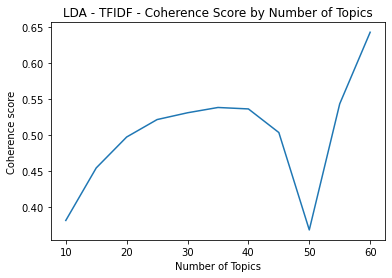

The best number of topics is 60


In [114]:
model_list_lda, coherence_values_lda = compute_coherence_values(dictionary=dictionary, corpus=tfidf_corpus,
                                                        texts=text_data, start=min_topics, 
                                                        limit=max_topics, step=step, analysis='LDA')

# Plot coherence scores
best_num_lda = plot_coherence_scores(min_topics, max_topics, step, model_list_lda, coherence_values_lda, 
                                       'LDA - TFIDF')

In [115]:
## overriding the best number

best_num_lda = 40

### Create Model with Appropriate Topic Number - LDA TFIDF

In [116]:
# lda_model = gensim.models.LdaModel(tfidf_corpus, num_topics=best_num_lda, id2word=dictionary, 
#                                         passes=10, random_state = 0)

lda_model = gensim.models.LdaModel(tfidf_corpus, num_topics=best_num_lda, id2word=dictionary, 
                                        iterations = 100, passes=10)

print_topic_examples(lda_model, "LDA - TFIDF")

The first 3 topics of the LDA - TFIDF model:
-----------------------------------------------

Topic: 28 
Words: 0.065*"medium" + 0.057*"economic" + 0.050*"charge" + 0.048*"star" + 0.047*"moment" + 0.046*"come" + 0.042*"aide" + 0.042*"facebook" + 0.040*"billion" + 0.039*"ohio"
Topic: 0 
Words: 0.094*"vote" + 0.082*"vaccine" + 0.081*"news" + 0.063*"fight" + 0.057*"key" + 0.057*"trial" + 0.047*"senate" + 0.036*"mcconnell" + 0.033*"online" + 0.031*"impeachment"
Topic: 4 
Words: 0.157*"back" + 0.099*"dc" + 0.098*"political" + 0.089*"call" + 0.074*"expert" + 0.062*"fbi" + 0.046*"might" + 0.040*"foreign" + 0.037*"stay" + 0.031*"dog"


Our LDA - TFIDF model's top 3 predicted topic for the following headline:
In contrast with Trump legal team, Justice Department lawyer says House can impeach over defied subpoenas
------------------------------------------------------------------------------------------

Score: 0.422	 
Topic: 0.078*"question" + 0.069*"death" + 0.058*"stimulus" + 0.050*"team" + 0

### Assign Dominant Topic per Headline - LDA TFIDF

In [117]:
# dataframe indicating which topic to assign each document
if analyze_headlines:
    column_name = 'Headline_Topic_LDA'
else:
    column_name = 'Article_Topic_LDA'


df_dominant_topics_lda = determine_dominant_topics(lda_model, tfidf_corpus, text_data)

# Format
df_dominant_topics_lda = df_dominant_topics_lda.reset_index()
df_dominant_topics_lda.columns = ['Document_No', column_name, 'Topic_%', 'Keywords', 'Text']
df_dominant_topics_lda[column_name] = df_dominant_topics_lda[column_name].astype(int)
df_dominant_topics_lda["Topic_%"] = round(df_dominant_topics_lda["Topic_%"]*100)

df[column_name] = df_dominant_topics_lda[column_name]
# df.head()

### Most Representative Headline per Topic - LDA TFIDF

In [ ]:
# show_representative_headlines(df_dominant_topics_lda, column_name).head(20)

### Number of Headlines per Topic - LDA TFIDF

In [118]:
topic_counts_lda = df_dominant_topics_lda[column_name].value_counts()

# Percentage of Documents for Each Topic
topic_contribution_lda = 100*round(topic_counts_lda/topic_counts_lda.sum(), 3)

# topic Keywords
topic_num_keywords_lda = df_dominant_topics_lda[['Keywords']]

# concatenate Column wise
df_dominant_topics_lda = pd.concat([topic_num_keywords_lda, topic_counts_lda, topic_contribution_lda], axis=1)

# adjust dataframe
df_dominant_topics_lda.columns = ['Topic_Keywords', 'Num_Documents', '%_Documents']
df_dominant_topics_lda = df_dominant_topics_lda.head(best_num_lda)
df_dominant_topics_lda.insert(0, "Topic", df_dominant_topics_lda.index.astype(int))

df_dominant_topics_lda = df_dominant_topics_lda.fillna(0.0)

df_dominant_topics_lda.Num_Documents = df_dominant_topics_lda.Num_Documents.astype(int)

# df_dominant_topics_lda.head()

top_lda_topics = df_dominant_topics_lda.sort_values(by='Num_Documents', ascending = False).head()

### Plot Distribution of Topics Between Sources - TFIDF

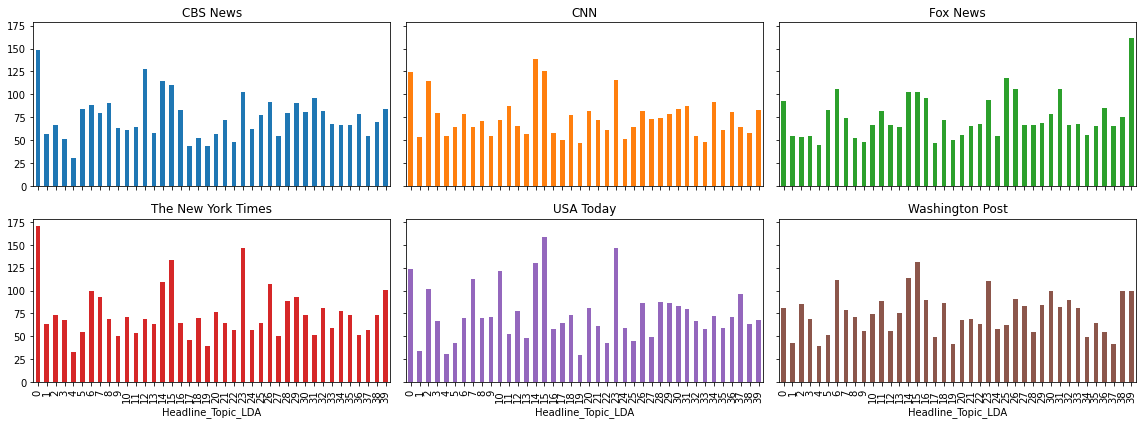

In [119]:
grouped_by_topic_source_lda = df.groupby(['source', column_name])

counts_per_source_lda = grouped_by_topic_source_lda[column_name].count()  # series with multi index

display_images = True

if display_images:
    
    ax = counts_per_source_lda.unstack(level=0).plot(kind='bar', subplots=True,
                                                 sharey=True, rot=90, figsize=(16, 6), layout=(2, 3), legend=False)
    plt.tight_layout()

In [ ]:
# !pip install -qq -U gensim
# !pip install spacy -qq
# !pip install seaborn -qq
# !python -m spacy download en_core_web_md -qq

# import seaborn as sns
# sns.set()
# import spacy

# import en_core_web_md

In [120]:
pyLDAvis.enable_notebook()

# if display_images:
    
lda_viz_tfidf = gensimvis.prepare(lda_model, tfidf_corpus, dictionary)
lda_viz_tfidf

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15     0.197662  0.112189       1        1  3.559073
14     0.071391 -0.179603       2        1  3.170128
23    -0.023066 -0.154315       3        1  3.167095
39    -0.127893  0.027875       4        1  2.844125
6      0.000156 -0.046455       5        1  2.789392
7      0.051492  0.134542       6        1  2.750014
29     0.156005 -0.073270       7        1  2.687734
30     0.095903  0.123487       8        1  2.657679
18     0.149052  0.091529       9        1  2.646882
12     0.022077  0.105947      10        1  2.633483
31    -0.035683  0.095244      11        1  2.630400
32    -0.051901  0.107359      12        1  2.625464
10    -0.068858  0.051021      13        1  2.615908
0      0.078944  0.036893      14        1  2.596644
27    -0.024053  0.053887      15        1  2.560521
26    -0.015115  0.011097      16        1  2.551913
38    -0.091810  0.028019      17        1  2.527839
11    -0.060903 -0.103834      18        1  2.516904
20     0.203739 -0.132738      19        1  2.476123
25    -0.157146 -0.004994      20        1  2.461629
2      0.192630  0.075647      21        1  2.459515
8     -0.069806 -0.044260      22        1  2.451885
37    -0.020100 -0.091835      23        1  2.444197
35    -0.062644 -0.104228      24        1  2.432017
21    -0.074444 -0.059712      25        1  2.421617
36     0.051198  0.058150      26        1  2.408912
3      0.061290  0.032980      27        1  2.395163
33    -0.111580  0.063649      28        1  2.394152
16    -0.102515 -0.034506      29        1  2.364938
28     0.015705 -0.108628      30        1  2.339093
9     -0.045496  0.064036      31        1  2.330270
13    -0.122672  0.069004      32        1  2.304336
34     0.136264 -0.119122      33        1  2.274078
5     -0.064718  0.122863      34        1  2.211560
19    -0.048772 -0.053894      35        1  2.197788
24    -0.005715 -0.038080      36        1  2.113048
4     -0.040007 -0.019178      37        1  2.046704
22    -0.111111 -0.031440      38        1  2.039435
1      0.042559 -0.006893      39        1  2.008978
17     0.009941 -0.058434      40        1  1.893359, topic_info=         Term        Freq       Total Category  logprob  loglift
321   opinion  276.000000  276.000000  Default  30.0000  30.0000
930  analysis  232.000000  232.000000  Default  29.0000  29.0000
222  pandemic  197.000000  197.000000  Default  28.0000  28.0000
53     report  134.000000  134.000000  Default  27.0000  27.0000
58       back  123.000000  123.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
358  official    4.585546   97.203949  Topic40  -5.0570   0.9129
258      make    4.639425  103.770600  Topic40  -5.0453   0.8592
130     state    5.739269  176.378091  Topic40  -4.8326   0.5415
72   democrat    5.396943  180.559639  Topic40  -4.8941   0.4566
4       trump    7.300328  642.464312  Topic40  -4.5920  -0.5106

[1336 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
671      22  0.972578     1
658      29  0.956503    10
890      22  0.969208   100
279      17  0.959502    15
345       3  0.863974     2
...     ...       ...   ...
48       31  0.075642  yous
48       32  0.041259  yous
48       34  0.165037  yous
48       35  0.006877  yous
48       39  0.075642  yous

[1576 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 15, 24, 40, 7, 8, 30, 31, 19, 13, 32, 33, 11, 1, 28, 27, 39, 12, 21, 26, 3, 9, 38, 36, 22, 37, 4, 34, 17, 29, 10, 14, 35, 6, 20, 25, 5, 23, 2, 18])

In [124]:
# pyLDAvis.save_html(lda_viz_tfidf, 'index.html')

## LSA Topic Modeling

https://medium.com/analytics-vidhya/text-mining-101-a-stepwise-introduction-to-topic-modeling-using-latent-semantic-analysis-using-add9c905efd9

https://www.kaggle.com/rajmehra03/topic-modelling-using-lda-and-lsa-in-sklearn

https://radimrehurek.com/gensim/models/lsimodel.html

The LSA/LSI model does not assign a topic to each document. It simply provides a value for each topic in every document. It does not correspond to the majority of a topic, just how the topic plays a role in the said document.

### Determine Best Number of Topics - LSA

In [ ]:
model_list_lsi, coherence_values_lsi = compute_coherence_values(dictionary=dictionary, 
                                                                            corpus=tfidf_corpus, texts=text_data, 
                                                                            start=min_topics, limit=max_topics, 
                                                                            step=step, analysis='LSI')

# Plot coherence scores
lsi_best_num = plot_coherence_scores(min_topics, max_topics, step, model_list_lsi, 
                                       coherence_values_lsi, 'LSI/LSA')

### Create Model with Appropriate Number of Topics - LSA

In [ ]:
from gensim.models import LsiModel

lsi_model = gensim.models.LsiModel(tfidf_corpus, num_topics=lsi_best_num, id2word=dictionary)

print("The first 3 topics of the LSI model:")
print("-----------------------------------------------\n")
    
for idx, topic in lsi_model.print_topics(num_topics=3):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

## HDP Model - TFIDF

The HDP model determines the number of topics on its own.

https://www.tutorialspoint.com/gensim/gensim_creating_lsi_and_hdp_topic_model.htm

In [ ]:
model_list_hdp, coherence_values_hdp = compute_coherence_values(dictionary=dictionary, 
                                                                            corpus=tfidf_corpus, texts=text_data, 
                                                                            start=min_topics, limit=max_topics, 
                                                                            step=step, analysis = 'HDP')

# Plot coherence scores
hdp_best_num = plot_coherence_scores(min_topics, max_topics, step, model_list_hdp, coherence_values_hdp, 'HDP')

In [ ]:
hdp_model = gensim.models.hdpmodel.HdpModel(corpus=tfidf_corpus, T = hdp_best_num, id2word=dictionary)

In [ ]:
coherencemodel = CoherenceModel(model=hdp_model, texts=text_data, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())

In [ ]:
print("The HDP Model created {} distinct topics\n\n".format(len(hdp_model.get_topics())))

print("The first 3 topics of the HDP model:")
print("-----------------------------------------------\n")

for idx, topic in hdp_model.print_topics(num_topics=3):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

In [ ]:
# out of the 15 topics shown there are none thatare about coronavirus or trump. weird.
# figure out how to interpret the output of HDP and LSA models.

# hdp_model.print_topics()
# df_dominant_topics_hdp = determine_dominant_topics(hdp_model, tfidf_corpus, texts=text_data)

# https://stackoverflow.com/questions/31543542/hierarchical-dirichlet-process-gensim-topic-number-independent-of-corpus-size

## Comparing Coherence Values of Models

In [ ]:
x_vals = list(range(min_topics, max_topics, step))

plt.plot(x_vals, coherence_values_hdp, color = 'green', label = 'HDP Model')
plt.plot(x_vals, coherence_values_lsi, color = 'blue', label = 'LSI Model')
plt.plot(x_vals, coherence_values_lda, color = 'red', label = 'LDA TFIDF Model')
plt.plot(x_vals, coherence_values_bow, color = 'gray', label = 'LDA BoW Model')
plt.xlabel("Number of Topics", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.ylim([.25, .9])
plt.legend(ncol=2, loc='upper center')
plt.title("Coherence Values Between Models and Topic Numbers")
plt.show()

# Sentiment Analysis - Top 5 Topics from LDA TF-IDF

## VADER Analysis

In [ ]:
if analyze_headlines:
    colname = 'headline_vader'
    original_column = 'orig_headline'
else:
    colname = 'article_vader'
    original_column = 'orig_article'

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments of the sentence.
threshold = 0.05

def sentiment_scores(df, text):

    sid_obj = SentimentIntensityAnalyzer()
    # polarity_scores method of SentimentIntensityAnalyzer. oject gives a 
    # sentiment dictionary. which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(text)

    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= threshold:
        return 'positive'
    elif sentiment_dict['compound'] <= -threshold:
        return 'negative'
    else:
        return 'neutral'

perform_vader = True

if perform_vader:
    
    df[colname] = np.empty((len(df), 0)).tolist()

    for index, row in df.iterrows():
        df[colname].iloc[index] = sentiment_scores(df, row[original_column])

In [ ]:
df.head()

### Plot Overall Sentiments Between Sources - VADER

In [ ]:
overall_sentiments_vader = overall_sentiment_counts(df, colname)

width = 0.15
N = 3
ind = np.arange(N)

if display_images:
    
    plt.figure(figsize = (14,7))
    plt.bar(ind, overall_sentiments_vader[0], width = 0.15, label = "CBS", color = 'darkorange')
    plt.bar(ind + width, overall_sentiments_vader[1], width = 0.15, label = "CNN", color = 'royalblue')
    plt.bar(ind + 2*width, overall_sentiments_vader[2], width = 0.15, label = 'Fox News', color = 'tab:red')
    plt.bar(ind + 3*width, overall_sentiments_vader[3], width = 0.15, label = 'NY Times', color = 'seagreen')
    plt.bar(ind + 4*width, overall_sentiments_vader[4], width = 0.15, label = 'USA Today', color = 'darkorchid')
    plt.bar(ind + 5*width, overall_sentiments_vader[5], width = 0.15, label = 'Wash. Post', color = 'silver')
    plt.title("Overall Sentiment Scores - VADER", fontsize = 14)
    plt.xticks(ind + 4.5*width / 2, ["Positive", "Neutral", "Negative"], fontsize=14)
    plt.ylim([0, 700])
    plt.legend(loc='upper center', bbox_to_anchor=(.5, .99), ncol=3, fancybox=True, shadow=True, fontsize = 14)
    plt.show()

### Determine Top 5 Most Frequent Topics

In [ ]:
# most outler list 5 : each topic
# x[2] is all sources and sentiment counts for topic 2

# middle list 6: each source
# x[1][4] is the 4th source for topic 1

# most inner list 3 : each emotion
# x[1][5][2] is the neutral emotion count for source 5 and topic 1

### Inter-source Number of Article Publications for Top 5 Topics

In [ ]:
top_5_topics = list(df_dominant_topics_lda.sort_values(by='Num_Documents', ascending=False).head()['Topic'])
article_counts = [[[0] for _ in range(6)] for _ in range(5)]

source_topic_sentiments_vader = topic_sentiment_counts(df, colname)

width = 0.15
N = 3
ind = np.arange(N)

if display_images:
    
    fig, ax = plt.subplots(5, 1, figsize=(7, 18), sharey=True, sharex=True)

    for i in range(len(top_5_topics)):

        keywords = df_dominant_topics_lda.loc[df_dominant_topics_lda['Topic'] == i, 
                                                'Topic_Keywords'].values[0]
        plt.cla()
        ax[i].bar(1, article_counts[i][0], label = "CBS", color = 'darkorange')
        ax[i].bar(2, article_counts[i][1], label = "CNN", color = 'royalblue')
        ax[i].bar(3, article_counts[i][2], label = 'Fox News', color = 'tab:red')
        ax[i].bar(4, article_counts[i][3], label = 'NY Times', color = 'seagreen')
        ax[i].bar(5, article_counts[i][4], label = 'USA Today', color = 'darkorchid')
        ax[i].bar(6, article_counts[i][5], label = 'Wash. Post', color = 'silver')
        ax[i].set_title("Articles published concerning Topic {}\nKeywords: {}".format(top_5_topics[i], keywords), 
                        fontsize = 14)
        ax[i].tick_params(axis='both', which='both', labelsize=12, labelbottom=True)
        ax[i].set_ylim([0, 100])
        ax[i].legend(loc='upper center', bbox_to_anchor=(.5, .99), ncol=3, fancybox=True, shadow=True)
        plt.xticks(range(1, 7), [])

    plt.subplots_adjust(bottom=0.1, top=1.1)
    plt.show()

## Plot Emotional Sentiments of Top 5 Topics - Separated by Source - VADER

Adjusted for number of articles in each topic per source

In [ ]:
width = 0.15
N = 3
ind = np.arange(N)

if display_images:
    
    fig, ax = plt.subplots(5, 1, figsize=(15, 25), sharey=True, sharex=True)

    for i in range(len(top_5_topics)):

        keywords = df_dominant_topics_lda.loc[df_dominant_topics_lda['Topic'] == i, 
                                                'Topic_Keywords'].values[0]
        
        ax[i].bar(ind, source_topic_sentiments_vader[i][0], width = .15, label = "CBS", color = 'darkorange')
        ax[i].bar(ind + width, source_topic_sentiments_vader[i][1], width = .15, label = "CNN", 
                  color = 'royalblue')
        ax[i].bar(ind + 2*width, source_topic_sentiments_vader[i][2], width = .15, label = 'Fox News', 
                  color = 'tab:red')
        ax[i].bar(ind + 3*width, source_topic_sentiments_vader[i][3], width = .15, label = 'NY Times', 
                  color = 'seagreen')
        ax[i].bar(ind + 4*width, source_topic_sentiments_vader[i][4], width = .15, label = 'USA Today', 
                  color = 'darkorchid')
        ax[i].bar(ind + 5*width, source_topic_sentiments_vader[i][5], width = .15, label = 'Wash. Post', 
                  color = 'silver')
        ax[i].set_title("Topic {} - Keywords: {}".format(top_5_topics[i], keywords), fontsize = 14)
        ax[i].tick_params(axis='both', which='both', labelsize=7, labelbottom=True)
        ax[i].legend(loc='best')
        plt.sca(ax[i])
        plt.xticks(ind + 4.5*width / 2, ["Positive", "Neutral", "Negative"], fontsize=14)
        plt.yticks(fontsize=12)


## TextBlob

In [ ]:
from textblob import TextBlob
from nltk.probability import FreqDist
nltk.download('brown')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

In [ ]:
def text_blob_scores(text):

    data = TextBlob(text)
    return data.sentiment[0], data.sentiment[1]

perform_text_blob = True

if perform_text_blob:
    
    if analyze_headlines:
        df['headline_polarity'] = np.empty((len(df), 0)).tolist()
        df['headline_subjectivity'] = np.empty((len(df), 0)).tolist()
        
        for index, row in df.iterrows():
        
            polarity, subjectivity = text_blob_scores(row['orig_headline'])
            df['headline_polarity'].iloc[index] = polarity
            df['headline_subjectivity'].iloc[index] = subjectivity
            
    else:
        df['article_polarity'] = np.empty((len(df), 0)).tolist()
        df['article_subjectivity'] = np.empty((len(df), 0)).tolist()

        for index, row in df.iterrows():

            polarity, subjectivity = text_blob_scores(row['orig_article'])
            df['article_polarity'].iloc[index] = polarity
            df['article_subjectivity'].iloc[index] = subjectivity

In [ ]:
# Classify the continuous scores

if perform_text_blob:

    if analyze_headlines:
        df['headline_polarity_class'] = np.empty((len(df), 0)).tolist()
        df.loc[df['headline_polarity'] < 0, 'headline_polarity_class'] = 'negative'
        df.loc[df['headline_polarity'] == 0, 'headline_polarity_class'] = 'neutral'
        df.loc[df['headline_polarity'] > 0, 'headline_polarity_class'] = 'positive'
        
    else:
        df['article_polarity_class'] = np.empty((len(df), 0)).tolist()
        df.loc[df['article_polarity'] < 0, 'article_polarity_class'] = 'negative'
        df.loc[df['article_polarity'] == 0, 'article_polarity_class'] = 'neutral'
        df.loc[df['article_polarity'] > 0, 'article_polarity_class'] = 'positive'
    

In [ ]:
# Plot polarity and subjectivity of textblob algorithm

colors = ['darkorange', 'royalblue', 'tab:red', 'seagreen', 'darkorchid', 'gray']

if display_images:
    
    fig, ax = plt.subplots(2,3, figsize=(14,8), sharex=True, sharey=True)

    i = 0
    j = 0
    text_subjectivity = []
    text_polarity = []

    for k in range(len(sources)):

        sub_df = df.loc[df['source'] == sources[k]]

        if analyze_headlines:
            text_subjectivity.append(sub_df['headline_subjectivity'])
            text_polarity.append(sub_df['headline_polarity'])
            ax[i][j].scatter(sub_df['headline_polarity'], sub_df['headline_subjectivity'], alpha = 0.2, 
                 color = colors[k])
            ax[i][j].set_title("{} Headline Text".format(sources[k], size = 22))
        else:
            text_subjectivity.append(sub_df['article_subjectivity'])
            text_polarity.append(sub_df['article_polarity'])
            ax[i][j].scatter(sub_df['article_polarity'], sub_df['article_subjectivity'], alpha = 0.2, 
                 color = colors[k])
            ax[i][j].set_title("{} Article Text".format(sources[k], size = 22))
        
        ax[i][j].set_ylabel('Subjectivity', fontsize = 14) # Y label
        ax[i][j].set_xlabel('Polarity', fontsize = 14) # X label

        j = j + 1
        if j == 3:
            j = 0               
            i = 1           

    fig.tight_layout()
    plt.show()

## Textblob - Polarity / Subjectivity Boxplots

In [ ]:
# https://matplotlib.org/3.1.0/gallery/statistics/boxplot.html

medianprops = dict(linestyle='-', linewidth=4, color='firebrick')

if display_images:
    
    fig, ax = plt.subplots(1, 2, figsize = (16,6), tight_layout=True, sharey=False)

    if analyze_headlines:
        ax[0].set_title('Headline Polarity', fontsize = 16)
        ax[1].set_title('Headline Subjectivity', fontsize = 16)
    else:
        ax[0].set_title('Article Polarity', fontsize = 16)
        ax[1].set_title('Article Subjectivity', fontsize = 16)
        
    ax[0].boxplot(text_polarity, medianprops=medianprops, sym='.', labels = sources)
    ax[1].boxplot(text_subjectivity, medianprops=medianprops, sym='.', labels = sources)

    plt.show()

In [ ]:
if analyze_headlines:
    overall_sentiments_blob = overall_sentiment_counts(df, 'headline_polarity_class')
else:
    overall_sentiments_blob = overall_sentiment_counts(df, 'article_polarity_class')

width = 0.15
N = 3
ind = np.arange(N)

if display_images:

    plt.figure(figsize = (14,7))
    plt.bar(ind, overall_sentiments_blob[0], width = 0.15, label = "CBS", color = 'darkorange')
    plt.bar(ind + width, overall_sentiments_blob[1], width = 0.15,label = "CNN", color = 'royalblue')
    plt.bar(ind + 2*width, overall_sentiments_blob[2], width = 0.15,label = 'Fox News', color = 'tab:red')
    plt.bar(ind + 3*width, overall_sentiments_blob[3], width = 0.15,label = 'NY Times', color = 'seagreen')
    plt.bar(ind + 4*width, overall_sentiments_blob[4], width = 0.15,label = 'USA Today', color = 'darkorchid')
    plt.bar(ind + 5*width, overall_sentiments_blob[5], width = 0.15, label = 'Wash. Post', color = 'silver')
    plt.title("Overall Sentiment Scores - TextBlob", fontsize = 14)
    plt.xticks(ind + 4.5*width / 2, ["Positive", "Neutral", "Negative"], fontsize=14)
    plt.ylim([0, 1100])
    plt.legend(loc='upper center', bbox_to_anchor=(.5, .99), ncol=3, fancybox=True, shadow=True, fontsize = 14)
    plt.show()

In [ ]:
if analyze_headlines:
    source_topic_sentiments_blob = topic_sentiment_counts(df, 'headline_polarity_class')
else:
    source_topic_sentiments_blob = topic_sentiment_counts(df, 'article_polarity_class')

width = 0.15
N = 3
ind = np.arange(N)

if display_images:
    
    fig, ax = plt.subplots(5, 1, figsize=(15, 25), sharey=True, sharex=True)

    for i in range(len(top_5_topics)):

        keywords = df_dominant_topics_lda.loc[df_dominant_topics_lda['Topic'] == i, 
                                                'Topic_Keywords'].values[0]

        ax[i].bar(ind, source_topic_sentiments_blob[i][0], width = .15, label = "CBS", color = 'darkorange')
        ax[i].bar(ind + width, source_topic_sentiments_blob[i][1], width = .15, label = "CNN", color = 'royalblue')
        ax[i].bar(ind + 2*width, source_topic_sentiments_blob[i][2], width = .15, label = 'Fox News', 
                  color = 'tab:red')
        ax[i].bar(ind + 3*width, source_topic_sentiments_blob[i][3], width = .15, label = 'NY Times', 
                  color = 'seagreen')
        ax[i].bar(ind + 4*width, source_topic_sentiments_blob[i][4], width = .15, label = 'USA Today', 
                  color = 'darkorchid')
        ax[i].bar(ind + 5*width, source_topic_sentiments_blob[i][5], width = .15, label = 'Wash. Post', 
                  color = 'silver')
        ax[i].set_title("Topic {} - Keywords: {}".format(top_5_topics[i], keywords), fontsize = 14)
        ax[i].tick_params(axis='both', which='both', labelsize=7, labelbottom=True)
        ax[i].legend(loc='best')
        plt.sca(ax[i])
        plt.xticks(ind + 4.5*width / 2, ["Positive", "Neutral", "Negative"], fontsize=14)
        plt.yticks(fontsize=12)

# Clustering

### https://medium.com/towards-data-science/another-twitter-sentiment-analysis-with-python-part-8-dimensionality-reduction-chi2-pca-c6d06fb3fcf3

In [ ]:
# import contractions

# expanded_words = []

# for word in list(df['orig_headline']):
    
#     expanded_words.append(contractions.fix(word)) # using contractions.fix to expand the shotened words

# headlines = expanded_words  # remove contractions
# headlines

In [ ]:
# # https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0
# import re

# # function to remove special characters
# def remove_special_characters(text):
    
#     pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # define the pattern to keep
    
#     return re.sub(pat, '', text)
 
# remove_specials = True
    
# if remove_specials:
#     special_chars = map(remove_special_characters, headlines)
#     headlines = list(special_chars)

## Creating a TF-IDF Matrix from the Original Text Input (no tokenization, etc.)

In [132]:
from sklearn.feature_extraction.text import TfidfVectorizer

freq_transformer = TfidfVectorizer()

text_tfidf = freq_transformer.fit_transform(original_text)
# text_tfidf # 6000 x 10,831 sparse matrix


## Principal Component Analysis

In [133]:
from sklearn.decomposition import TruncatedSVD

n_components = 1000

svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
svd.fit(text_tfidf)

# print(svd.explained_variance_ratio_.sum())
# print(svd.singular_values_)

pca_text = svd.transform(text_tfidf)

The explained variance of 1000 principal components is 0.51


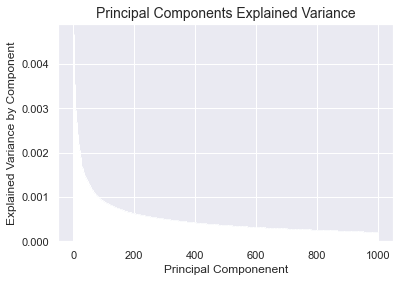

In [135]:
num_components = list(range(1, n_components+1))

if display_images:
    plt.bar(num_components, svd.explained_variance_ratio_)
    plt.title("Principal Components Explained Variance", fontsize=14)
    plt.xlabel("Principal Componenent")
    plt.ylabel("Explained Variance by Component")
    print("The explained variance of {} principal components is {:.2}".format(len(num_components), 
                                                                              svd.explained_variance_ratio_.sum()))

    plt.show()

## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

kmeans_dict = {}

cluster_number = [2, 3, 4, 5, 10]

# Create kMeans clustering algorithms using the subsampling data

for i in range(len(cluster_number)):
    kmeans = KMeans(n_clusters=cluster_number[i], random_state=0).fit(pca_text)
    kmeans_dict['clusters k={}'.format(cluster_number[i])] = kmeans
    df['kmeans k={}'.format(cluster_number[i])] = kmeans.predict(pca_text)
    
# df['kmeans k=5 predictions'] = kmeans_dict['clusters k=5'].predict(pca_text)
# df.head()

In [ ]:
if display_images:
    plot_pca(df['kmeans k=2'], pca_text)

In [ ]:
if display_images:
    plot_pca(pd.factorize(df['source'])[0], pca_text)

In [ ]:
if display_images:
    plot_pca(pd.factorize(df['headline_vader'])[0], pca_text)

## t-SNE 

In [ ]:
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from sklearn.manifold import TSNE

perplex = [5, 30, 50]
tsne_dict = {}

for i in perplex:
    tsne = TSNE(n_components=2, verbose=0, perplexity=i, n_iter=300)
    tsne_results = tsne.fit_transform(pca_text)
    tsne_dict["perplexity {}".format(i)] = tsne_results

In [ ]:
# T-SNE with news sources as the labels (colors)

if display_images:
    plot_tsne(pd.factorize(df['source'])[0])

In [ ]:
# T-SNE with the k-means k=5 cluster labels as the colors

if display_images:  
    plot_tsne(df['kmeans k=2'])

In [ ]:
# T-SNE with the positive-neutral-negative labels as the colors

if display_images:
    plot_tsne(pd.factorize(df['headline_vader'])[0])

## DBSCAN Clustering

In [ ]:
# pca_text_df = pd.DataFrame(pca_text)
# pca_text_df.head()

In [136]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(pca_text)
normalized_pca_text = scaler.transform(pca_text)

In [ ]:
# df_scaled = scaler.fit_transform(pca_text_df.to_numpy())
# df_scaled = pd.DataFrame(df_scaled)
 
# print("Scaled Dataset Using StandardScaler")
# df_scaled.head()

In [137]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
# nbrs = neigh.fit(pca_text)
nbrs = neigh.fit(normalized_pca_text)
distances, indices = nbrs.kneighbors(pca_text)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

### Determine Epsilon and Minpoint parameters for DBscan

Maximum curve occurs at point 17985
Epsilon at point 17985 = 3.57


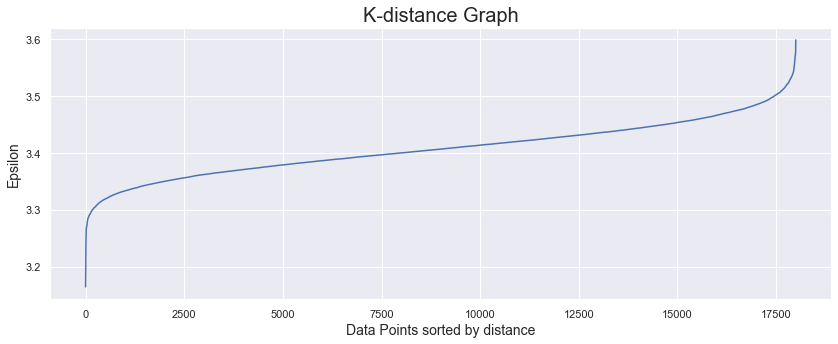

In [142]:
# https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/
# https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python

# !pip install kneed
from kneed import KneeLocator
kn = KneeLocator(np.arange(18000), distances, curve='convex', direction='increasing')

if display_images:

    plt.figure(figsize=(14,5))
    plt.plot(distances)
    plt.title('K-distance Graph',fontsize=20)
    plt.xlabel('Data Points sorted by distance',fontsize=14)
    plt.ylabel('Epsilon',fontsize=14)
    
    print("Maximum curve occurs at point {}".format(kn.knee))
    print("Epsilon at point {} = {:.3}".format(kn.knee, distances[kn.knee]))

    plt.show()

## Figure out DBScan Parameters

## Maybe the standard scalar on an array doesn't scale the data by 'column' but by individual rows? So try in a dataframe format?

In [ ]:
from sklearn.cluster import DBSCAN

min_points = [5, 10, 25, 100]
epsilons = [0.01, 0.05, 0.1, 0.5, 1.5, 5]


db_dict = {}

for number in min_points:
    
    for eps in epsilons:
        
        db = DBSCAN(eps=eps, min_samples=number).fit(normalized_pca_text)
        db_dict['epsilon: {} minpts: {}'.format(eps, number)] = db
        

In [ ]:
for keys, vals in db_dict.items():
    print(keys, "\nEstimated number clusters: {}\nEstimated noise {}\n".format(len(set(vals.labels_)), 
                                                                               list(vals.labels_).count(-1)))

In [ ]:
from sklearn import metrics

# Number of clusters in labels, ignoring noise if present.

for model in a.values():

    labels = model.labels_

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(model)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d\n" % n_noise_)
    
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
# )
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

## Compute Silhouette Scores and CH Index

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

silhouette_dict = {}
ch_dict = {}

for i in range(len(cluster_number)):
    silhouette_dict['k means k={}'.format(cluster_number[i])] = silhouette_score(pca_text, 
                                                             kmeans_dict['clusters k={}'.format(cluster_number[i])].predict(pca_text))
    ch_dict['k means k={}'.format(cluster_number[i])] = calinski_harabasz_score(pca_text, 
                                                             kmeans_dict['clusters k={}'.format(cluster_number[i])].predict(pca_text))

In [ ]:
from pprint import pprint

print("Silhouette Scores:")
pprint([(k, round(v, 3)) for k, v in sorted(silhouette_dict.items(), key=lambda x: x[1], reverse=True)])
print("\n CH Index:")
pprint([(k, round(v, 3)) for k, v in sorted(ch_dict.items(), key=lambda x: x[1], reverse=True)])

In [ ]:
# detokenized_doc = [] 

# for i in range(len(df['tokenized_headline'])): # tokenized headline because it has stop words removed
#     t = ' '.join(df['tokenized_headline'].iloc[i]) 
#     detokenized_doc.append(t) 

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer 
# vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.5, smooth_idf=True) 
# X = vectorizer.fit_transform(detokenized_doc) 
# # X.shape

In [ ]:
# from sklearn.decomposition import TruncatedSVD 
# # SVD represent documents and terms in vectors 
# svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122) 
# lsa_model = svd_model.fit_transform(X) 
# # len(svd_model.components_)

In [ ]:
# terms = vectorizer.get_feature_names() 

# for i, comp in enumerate(svd_model.components_): 
#     terms_comp = zip(terms, comp) 
#     sorted_terms = sorted(terms_comp, key= lambda x:x[1],        
#     reverse=True)[:7] 
#     print("Topic "+str(i)+": ") 
#     for t in sorted_terms: 
#         print(t[0])
#     print()

In [ ]:
# lsa_topic_assignments = []

# for i in range(len(df)):
#     l = lsa_model[i]
#     max_value = l.max()
#     assignment = list(l).index(max_value)
#     lsa_topic_assignments.append(assignment)

# # lsa_topic_assignments
# df['LSA_Topic'] = lsa_topic_assignments

In [ ]:
# grouped_by_topic_source_lsa = df.groupby(['source', 'LSA_Topic'])

# counts_per_source_lsa = grouped_by_topic_source_lsa['LSA_Topic'].count()  # series with multi index

# if display_images:
    
#     ax = counts_per_source_lsa.unstack(level=0).plot(kind='bar', subplots=True,
#                                                  sharey=True, rot=90, figsize=(16, 6), layout=(2, 3), legend=False)
#     plt.tight_layout()

In [ ]:
# import pickle

# with open('dbscan_dictionary.pickle', 'wb') as handle:
#     pickle.dump(db_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
# df_dominant_topic.set_index('Document_No', inplace=True)
# df_dominant_topic.index
# df.index
# df_dominant_topic_bow.head()

In [ ]:
# subset of the assignment dataframe to join with the main df
# topic_assignments_bow = df_dominant_topic_bow[['Document_No', column_name]]

# # drop to reassign topics - potentially changed when model re-run
# if repull_data and column_name in df.columns:
#     df = df.drop(column_name ,axis=1)

# df['Document_No'] = range(0, len(df))
# df.set_index('Document_No', inplace=True)
# df = df.join(topic_assignments_bow.set_index('Document_No'))
# df.head()

In [ ]:
# # provide a dominant topic label for each text input

# def determine_dominant_topics(model, corpus, texts):
#     # Init output
#     sentence_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row in enumerate(model[corpus]):
        
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
#         # j is the index, topic_num and prop_topic are a tuple corresponding to the topic number and percent contribution of the document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => the first element in the row (index 0) is the dominant topic. the first element of that tuple is the topic num
                
#                 wp = model.show_topic(topic_num)  # topic information for the dominant topic number
#                 topic_keywords = ", ".join([word for word, prop in wp]) # just keywords for the topic number
#                 sentence_topics_df = sentence_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), 
#                                                                   topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sentence_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sentence_topics_df = pd.concat([sentence_topics_df, contents], axis=1)
#     return(sentence_topics_df)

In [ ]:
# limit = 100

# k = 0
# for i, row in enumerate(lda_model_tfidf[tfidf_corpus]):
        
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)  # sort the topics so majority topic first
        
#         # enumerate all 20 elements (topics) of each row. each row has 20 topics. each topic has an associated value with that headline
#         for j, (topic_num, prop_topic) in enumerate(row):  
#             if j ==0: # index 0: first topic is the dominant
#                 print("Lemmatized Headline", text_data[k]) # the text data for the headline
#                 print("Topic", topic_num)  # the topic number
#                 print("Topic Keywords", lda_model_tfidf.show_topic(topic_num))  # keywords and probabilities for the topic number
#                 print(", ".join([word for word, prop in lda_model_tfidf.show_topic(topic_num)])) # just keywords for topic number
            
#             if k > limit:
#                 break
                
#         k += 1
#         print()
        
#         if k > limit:
#             break
            
            
            
#         print(len(row))
#         print(row)

#         if len(row) == 0:
#             print(k-1, text_data[k-1])


### News sources and the number of articles

NY Times ------- 2018: 5,471 ----- 2019: 6,051 ------ 2020: 19,805     
CBS News ------ 2018: 5,397 ----- 2019: 6,758 ------ 2020: 26,634    
Fox News ------- 2018: 3,106 ----- 2019: 5,599 ------ 2020: 19,748   
Wash Post ------ 2018: 1,252 ----- 2019: 1,462 ------ 2020: 19,530   
CNN News ------ 2018: 8,202 ----- 2019: 7,766 ------ 2020: 25,511   
USA Today ------ 2018: 5,968 ----- 2019: 6,061 ------ 2020: 13,374   

In [ ]:
# # save the model to disk
# filename = 'lda_sample_ten_topic_bow.sav'
# pickle.dump(model, open(filename, 'wb'))
 
# # some time later...
 
# # load the model from disk
# # loaded_model = pickle.load(open(filename, 'rb'))
# # result = loaded_model.score(X_test, Y_test)
# # print(result)

In [ ]:
# import sqlite3 as sql
 
# cnx_2018 = sql.connect('../Data/2018_articles.db')
# cnx_2019 = sql.connect('../Data/2019_articles.db')
# cnx_2020 = sql.connect('../Data/2020_articles.db')

In [ ]:
# import ast

# df['tokenized_headline'] = df['tokenized_headline'].apply(lambda x: ast.literal_eval(x))
# df['tokenized_article'] = df['tokenized_article'].apply(lambda x: x.strip('][').split(', '))
# df['tokenized_article'] = df['tokenized_article'].apply(lambda x: ast.literal_eval(x))

In [ ]:
# topic_assignments_tfidf = df_dominant_topics_tfidf[['Document_No', column_name]]

# # drop to reassign topics - potentially changed when model re-run

# # if 'Dominant_Topic_TFIDF'in df.columns:
# #     df = df.drop('Dominant_Topic_TFIDF',axis=1)

# df = df.join(topic_assignments_tfidf.set_index('Document_No'))
# df['Dominant_Topic_TFIDF'] = df['Dominant_Topic_TFIDF'].astype(int)
# # df.head()

In [ ]:
# df[column_name] = df_dominant_topics_tfidf[column_name]
# df.head()

In [ ]:
# df2018 = pd.read_excel("2018_articles.xlsx")
# df2019 = pd.read_excel("2019_articles.xlsx")
# df2020 = pd.read_excel("2020_articles.xlsx")

# df = df.append(df2018).append(df2019)

In [ ]:
# df = pd.read_sql_query("SELECT * FROM newsdata WHERE source LIKE '%newyorktimes%'", 
#                   cnx_2020)

In [ ]:
# sources = ['newyorktimes', 'cbs', 'foxnews', 'washingtonpost', 'cnn', 'usatoday']

# df = pd.DataFrame()

# for source in sources:

#     temp = pd.read_sql_query("SELECT * FROM newsdata WHERE source LIKE '%{}%'".format(source), 
#                       cnx_2020)
#     df = df.append(temp)

In [ ]:
# df = df.drop(columns=['id', 'author', 'url', 'published', 'published_utc', 'collection_utc'])

In [ ]:
# df = df.rename({'title': 'name'}, axis=1)

In [ ]:
# df = df.replace("cnn", "CNN")
# df = df.replace("washingtonpost", "Washington Post")
# df = df.replace("cbsnews", "CBS News")
# df = df.replace("foxnews", "Fox News")
# df = df.replace("thenewyorktimes", "The New York Times")
# df = df.replace("usatoday", "USA Today")

# df['source'].unique()

In [ ]:
# df = df.drop(df[df['source'].str.contains('cbssports')].index.tolist())

In [ ]:
# df.to_excel("all_years_subsample.xlsx")

In [ ]:
# pd.read_sql_query("SELECT DISTINCT(source), COUNT(*) AS 'Number' FROM articles WHERE source LIKE '%new york times%' GROUP BY(source) ORDER BY Number DESC LIMIT(25)", 
#                   cnx_2018)


In [ ]:
# pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", cnx_2019)
# pd.read_sql_query("SELECT DISTINCT(source), COUNT(*) AS 'Number' FROM newsdata GROUP BY(source) ORDER BY Number DESC LIMIT(25)", cnx_2019)
# pd.read_sql_query("SELECT DISTINCT(source), COUNT(*) FROM newsdata WHERE source LIKE '%usatoday%' GROUP BY(source) ORDER BY COUNT(*) DESC LIMIT 25", 
#                   cnx_2019)


In [ ]:
# pd.read_sql_query("SELECT DISTINCT(source), COUNT(*) AS 'Number' FROM newsdata WHERE source LIKE 'usatoday' GROUP BY(source) ORDER BY Number DESC LIMIT(25)", 
#                   cnx_2020)
